In [21]:
import librosa
import numpy as np
from numpy import inf
import IPython.display as ipd
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import scipy.signal as sg
import copy

In [28]:
WAVE_PATH = './hyojinparis.wav'

wave, fs = librosa.load(WAVE_PATH)

In [29]:
class FeatureExtraction:
    def __init__(self, wave, fs, frame_sample_ms=100, shift_sample_ms=50):
        self.wave = wave
        self.fs = fs
        self.frame_len = int(frame_sample_ms*self.fs/1000)
        """frame_len = len_sample(ms)만큼의 samples"""
        self.frame_shift = int(shift_sample_ms*self.fs/1000)        
        self.stft = librosa.stft(self.wave, n_fft=self.frame_len,
                                 hop_length=self.frame_shift)
        self.abs_stft = np.abs(self.stft)
        self.freqs = librosa.core.fft_frequencies(n_fft=self.stft.shape[0]*2-1,
                                                 sr=self.fs)
        
    def extract_entropy(self):
        """
        input: abs_stft, ndarray([f, t])
        f: magnitude of frequency bin f
        t: time domain bin
        output: entropy
        todo: entropy 계산 후 nan과 inf 제거한 뒤 리턴
        """
        print("Extracting Entropy...")
        square_abs_stft = self.abs_stft ** 2
        div_square_abs_stft = square_abs_stft / np.sum(square_abs_stft, axis=0)
        entropy_array = div_square_abs_stft * np.log2(div_square_abs_stft) * (-1)
        entropy = np.sum(entropy_array, axis=0)
        entropy[entropy == inf] = 0
        entropy = np.nan_to_num(entropy)
        print("\Entropy/")
        return entropy
    
    # Pitch Estimation
    def _extract_piptrack(self):
        frames = librosa.util.frame(self.wave,
                                    frame_length=self.frame_len,
                                    hop_length=self.frame_shift)
        pitches, magnitudes = librosa.core.piptrack(self.wave,
                                                    sr=self.fs,
                                                   hop_length=self.frame_shift,
                                                   threshold=0.75)
        return pitches
    
    def _extract_max(self, pitches, shape):
        new_pitches = []
        for i in range(0, shape[1]):
            new_pitches.append(np.max(pitches[:,i]))
        return new_pitches
    
    def _smooth(self, x, window_len=30, window='hanning'):
        """window_len 높아질수록 smooth해짐"""
        print("Wave smoothing...")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        print("~Smooth~")
        return y[window_len:-window_len+1]
    
    def pitch_estimation(self, window_len=10,
                        feature_type="smooth"):
        """
        params:
        window_len: int, smooth 정도 결정, 높으면 부드러워짐
        output:
        pitch_smoothtrack:
        pitch 리턴
        ndarray([self.stft.shape[1],])
        """
        print("Extracting Pitch...")
        pitches = self._extract_piptrack()
        pitch_track = self._extract_max(pitches, pitches.shape)
        if feature_type=="origin":
            return pitch_track
        elif feature_type=="smooth":
            pass
        else:
            raise("please write correct type: origin or smooth")        
        pitch_smoothtrack = self._smooth(pitch_track, window_len)
        print("\Pitch/")
        return pitch_smoothtrack
        
        
    # harmonics
    def _get_hpeak(self):
        """stft의 peak array를 구하는 함수"""
        hpeak = np.zeros_like(self.stft)
        fk = np.zeros((self.stft.shape[1],))
        for i in range(self.stft.shape[1]):
            abs_stft = np.abs(self.stft[:, i])
            flag = 0
            for idx, elm in enumerate(abs_stft): # check peak
                if (idx == 0) or (idx == self.stft.shape[0] - 1):
                    pass
                else:
                    if (abs_stft[idx]>abs_stft[idx-1]) and (abs_stft[idx] > abs_stft[idx+1]):
                        hpeak[idx, i] = elm
                        if flag==0:
                            fk[i,] = idx
                            flag = 1
                    else:
                        pass
        return hpeak, fk

    
    def _get_column_harmonic(self, column_hpeak):
        idx_col = np.where(column_hpeak != 0.0)[0]
        N = idx_col.shape[0]
        if N==0:
            return 0
        mean_col = 0.0
        var_col = 0.0
        dist_col = 0.0
        tmp = 0.0
        
        for idx in idx_col:
            tmp = column_hpeak[idx]
            mean_col += tmp
        mean_col = mean_col/N
        tmp = 0.0
        
        for idx in idx_col:
            tmp = (column_hpeak[idx]-mean_col)**2
            var_col += tmp
        var_col = var_col/N
        tmp = 0.0
        for idx, elm in enumerate(idx_col):
            if idx != 0:
                tmp = (np.abs(column_hpeak[idx_col[idx]] - column_hpeak[idx_col[idx-1]]))/N
            else:
                tmp = column_hpeak[idx] / N
            dist_col += tmp
        return dist_col  
    
    def _get_all_harmonics(self, hpeak):
        blank_array = np.zeros((hpeak.shape[1],))
        for i in range(hpeak.shape[1]):
            blank_array[i] = self._get_column_harmonic(hpeak[:,i])
        all_harmonics = blank_array
        return all_harmonics
    
    def extract_harmonics(self, window_len=10,
                         feature_type="smooth"):
        """
        todo: extract harmonics
        output: harmonic array
        """
        print("Extracting Harmonics...")
        hpeak, fk = self._get_hpeak()
        harmonics = self._get_all_harmonics(hpeak=hpeak)
        if feature_type=="origin":
            return harmonics
        elif feature_type=="smooth":
            pass
        else:
            raise("please write correct type: origin or smooth")        
        smooth_harmonics = self._smooth(harmonics, window_len)
        print("\Harmonics/")
        return smooth_harmonics
    
    
    # SEM
    def _f_to_bark(self):
        bark_freqs = 13*np.arctan(0.00076*self.freqs)+3.5*np.arctan(((self.freqs/7500)**2))
        bark_freqs_bin = bark_freqs.astype(int)
        bark_freqs_bin = bark_freqs_bin + 1
        zeroscore_idx = np.where(self.freqs < 20)[0]
        if zeroscore_idx.shape[0] != 0:
            for idx in zeroscore_idx:
                bark_freqs_bin[idx] = 0

        return bark_freqs_bin
    
    def _make_mu(self, bf):
        N = bf[-1]+1
        fre_sum = np.sum(self.abs_stft, axis=0)
        mu = fre_sum / N
        return mu
    
    def _get_column_B(self, stft_column, bf):
        N = bf[-1] + 1
        b_shell = np.arange(N, dtype=float)
        stft_column = np.abs(stft_column)
        for i in range(N):
            idx_arr = np.where(bf == i)[0]
            toadd = 0.0
            for idx in idx_arr:
                toadd += stft_column[idx]
                
            b_shell[i] = toadd
        
        return b_shell
    
    def _get_all_column_B(self, bf):
        n = self.stft.shape[1]
        for i in range(n):
            forreshape = self._get_column_B(self.stft[:,i], bf)
            forstack = forreshape.reshape((forreshape.shape[0], 1))
            if i ==0:
                forreturn = forstack
            else:
                forreturn = np.hstack([forreturn, forstack])
        B = forreturn
        
        return B
    
    def _get_hat_element(self, B, mu):
        """
        todo: get muhat, sigmahat
        params:
        B:
        mu:
        output:
        muhat: ndarray([1, stft.shape[1]])
        sigmahat: ndarray([1, stft.shape[1]])
        """
        pmin = np.min(B, axis=0)
        psr = (B - pmin)/mu
        Bbar = B * psr
        muhat = np.nan_to_num(np.mean(Bbar, axis=0))
        sigmahat = np.nan_to_num(np.sqrt(np.mean((Bbar - muhat)**2, axis=0)))
        return muhat, sigmahat
    
    def extract_sem_element(self, window_len=10,
                           feature_type="smooth"):
        print("Extract SEM...")
        bark_frequency = self._f_to_bark()
        B = self._get_all_column_B(bark_frequency)
        mu = self._make_mu(bark_frequency)
        muhat, sigmahat = self._get_hat_element(B, mu)
        if feature_type=="origin":
            return muhat+sigmahat
        elif feature_type=="smooth":
            pass
        else:
            raise("please write correct type: origin or smooth")        
        smooth_muhat = self._smooth(muhat, window_len)
        smooth_sigmahat = self._smooth(sigmahat, window_len)
        print("\SEM/")
        return smooth_muhat + smooth_sigmahat
    
    # Short-term energy
    def extract_short_term_energy(self, window_len=10,
                                 feature_type='smooth'):
        print("Extract Short time Energy...")
        sqrt_abs_stft = self.abs_stft**2
        lenframe = self.stft.shape[0]
        ste = np.sum(sqrt_abs_stft, axis=0)/lenframe
        if feature_type=="origin":
            return ste
        
        elif feature_type=="smooth":
            pass
        else:
            raise("please write correct type: origin or smooth")
            
        smooth_ste = self._smooth(ste, window_len)
        print("\ShortTimeEnergy/")
        return smooth_ste
    
    # Zero-crossing rate
    def extract_zcr(self, pad=0, window_len=0, feature_type='smooth'):
        """
        todo:
        extract zero crossing rate
        params:
        pad: wave에 일정 padding을 주어서 zcr값을 조정.
        pad의 절대값이 커지면 줄어드는 경향
        output:
        zero crossing rate
        """
        print("Extract ZCR")
        zcr = librosa.feature.zero_crossing_rate(self.wave+pad,
                                                frame_length=self.frame_len,
                                                hop_length=self.frame_shift)
        zcr = zcr[0]
        if feature_type=="origin":
            return zcr
        elif feature_type=="smooth":
            pass
        else:
            raise("please write correct type: origin or smooth")
            
        smooth_zcr = self._smooth(zcr, window_len)
        print("\ZCR/")
        return smooth_zcr
    
    def normalization(self, feature):
        feature = np.nan_to_num(feature)
        return feature/np.max(feature)
    
    def divide_norm_value(self, son, mother, window_len=10):
        """
        todo:
        Harmonic/Entropy
        """
        value = son/mother
        norm_value = self.normalization(value)
        smooth_norm_value = np.nan_to_num(norm_value)
        try:
            smooth_norm_value[inf]=0
        except:
            pass
        return smooth_norm_value
        
    def get_wave_point(self,
                       cl=0.03,
                       cut_eh=0.95,
                       cut_n=0.95):
        
        smhar = self.extract_harmonics()
        sment = self.extract_entropy()
        norm_eh = self.normalization(smhar/sment)
        nmask = self.extract_sem_element()
        norm_nmask = self.normalization(nmask)
        
        toadd = 0.0
        floor_norm_eh = np.zeros_like(norm_eh)
        for i in range(20):
            toadd = 1-cl*i
            floor_norm_eh += np.floor(norm_eh+toadd)
            
        floor_norm_eh = floor_norm_eh/np.max(floor_norm_eh)
        floor_norm_eh = np.floor(floor_norm_eh+cut_eh)
        floor_n = np.floor(norm_nmask+cut_n)
        
        to_minus_arr = np.zeros_like(floor_n)
        for idx, elm in enumerate(floor_norm_eh):
            if elm == 1:
                if floor_n[idx] == 0:
                    to_minus_arr[idx] = 1
        self.vad_value = floor_norm_eh - to_minus_arr
        self.vad_value[self.vad_value==inf]=0
        self.vad_value[self.vad_value==-inf]=0
        return self.vad_value
    
    def check_speech(self, vad_value, frameoffset=5):
        """
        ehmask를 frameoffset을 주는 함수
        hangover
        """
        ehmask=np.copy(vad_value)
        ehmask[-1]=0
        startflag=0
        startpoint = 0
        endpoint = 0
        detectset = []
        for idx, elm in enumerate(ehmask):
            if idx < ehmask.shape[0]-4: 
                if startflag==0: #startpoint를 찾아야돼!
                    if (ehmask[idx]==1 # speech start 확인
                       and (ehmask[idx+1]+ehmask[idx+2])!=0
                       and ehmask[idx+3]==1):
                        startflag = 1
                        startpoint = idx
                else: #endpoint 찾기, startflag==1
                    if (ehmask[idx]==0 
                       and (ehmask[idx+1]+ehmask[idx+2])!=2
                       and ehmask[idx+3]==0):
                        endpoint = idx
                        startflag=0
                        detectset.append((startpoint, endpoint))
            else:
                if startflag==1:
                    if ehmask[idx]==0:
                        endpoint = idx
                        startflag=0
                        detectset.append((startpoint, endpoint))
        if len(detectset)>=1:
            for i in detectset:
                startcut=frameoffset
                endcut=frameoffset
                if i[0]<=5:
                    startcut=i[0]
                else:
                    pass
                if i[1] >= (ehmask.shape[0]-endcut+1):
                    endcut = ehmask.shape[0]-i[1]
                else:
                    pass
                ehmask[(i[0]-startcut):(i[1]+endcut)]=1
        else:
            raise "Can't detect speech part."
        frameoffset_vad = np.copy(ehmask)
        return frameoffset_vad
    
    # Post processing
    def denoise_after_vad(self, frameoffset_vad):
        finalarray = np.copy(frameoffset_vad)
        for idx, elm in enumerate(finalarray):
            if (idx>=7) and (idx <= finalarray.shape[0]-1-10): # 양끝고려
                if (finalarray[idx] == 1 and # 010
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 0):
                    if np.sum(finalarray[idx-5:idx-1])==4:
                        finalarray[idx-5:idx] = 1
                    elif np.sum(finalarray[idx+2:idx+6])==4:
                        finalarray[idx:idx+6] = 1
                    elif np.sum(finalarray[idx-6:idx-2])==4:
                        finalarray[idx-6:idx] = 1
                    elif np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7] = 1
                    elif np.sum(finalarray[idx-7:idx-3])==4:
                        finalarray[idx-7:idx] = 1
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    else:
                        finalarray[idx] = 0

                elif (finalarray[idx] == 1 and # 0110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+2] == 0):
                    if np.sum(finalarray[idx-5:idx-1])==4:
                        finalarray[idx-5:idx] = 1
                    elif np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7] = 1
                    elif np.sum(finalarray[idx-6:idx-2])==4:
                        finalarray[idx-6:idx] = 1
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx-7:idx-3])==4:
                        finalarray[idx-7:idx] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    else:
                        finalarray[idx] = 0
                        finalarray[idx+1] = 0

                elif (finalarray[idx] == 1 and # 01110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+2] == 1 and
                    finalarray[idx+3] == 0):
                    if np.sum(finalarray[idx-5:idx-1])==4:
                        finalarray[idx-5:idx] = 1
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx-6:idx-2])==4:
                        finalarray[idx-6:idx] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    elif np.sum(finalarray[idx-7:idx-3])==4:
                        finalarray[idx-7:idx] = 1
                    elif np.sum(finalarray[idx+6:idx+10])==4:
                        finalarray[idx:idx+10] = 1
                    else:
                        finalarray[idx] = 0    
                        finalarray[idx+1] = 0
                        finalarray[idx+2] = 0
            if idx<7:
                if idx==0:
                    finalarray[idx]=0
                if 0<idx<6:
                    if (finalarray[idx] == 1 and # 010
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 0):
                        if np.sum(finalarray[idx+1:idx+5])==4:
                            finalarray[idx:idx+5]=1
                        elif np.sum(finalarray[idx+2:idx+6])==4:
                            finalarray[idx:idx+6]=1
                        elif np.sum(finalarray[idx+3:idx+7])==4:
                            finalarray[idx:idx+7]=1
                        else:
                            finalarray[idx]=0

                    elif (finalarray[idx] == 1 and # 0110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+1] == 0):
                        if np.sum(finalarray[idx+3:idx+7])==4:
                            finalarray[idx:idx+7] = 1
                        elif np.sum(finalarray[idx+4:idx+8])==4:
                            finalarray[idx:idx+8] = 1
                        elif np.sum(finalarray[idx+5:idx+9])==4:
                            finalarray[idx:idx+9] = 1
                        else:
                            finalarray[idx] = 0
                            finalarray[idx+1] = 0


                    elif (finalarray[idx] == 1 and # 01110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+2] == 1 and
                    finalarray[idx+3] == 0):
                        if np.sum(finalarray[idx+4:idx+8])==4:
                            finalarray[idx:idx+8] = 1
                        elif np.sum(finalarray[idx+5:idx+9])==4:
                            finalarray[idx:idx+9] = 1
                        elif np.sum(finalarray[idx+6:idx+10])==4:
                            finalarray[idx:idx+10] = 1
                        else:
                            finalarray[idx] = 0    
                            finalarray[idx+1] = 0
                            finalarray[idx+2] = 0

                if idx==6:
                    if (finalarray[idx] == 1 and # 010
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 0):
                        if np.sum(finalarray[1:5])==4:
                            finalarray[idx-1:idx+1]=0
                        elif np.sum(finalarray[idx+1:idx+5])==4:
                            finalarray[idx:idx+5]=1
                        elif np.sum(finalarray[idx+2:idx+6])==4:
                            finalarray[idx:idx+6]=1
                        elif np.sum(finalarray[idx+3:idx+7])==4:
                            finalarray[idx:idx+7]=1
                        else:
                            finalarray[idx]=0

                    elif (finalarray[idx] == 1 and # 0110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+1] == 0):
                        if np.sum(finalarray[1:5])==4:
                            finalarray[idx-1:idx+1]=0
                        elif np.sum(finalarray[idx+3:idx+7])==4:
                            finalarray[idx:idx+7] = 1
                        elif np.sum(finalarray[idx+4:idx+8])==4:
                            finalarray[idx:idx+8] = 1
                        elif np.sum(finalarray[idx+5:idx+9])==4:
                            finalarray[idx:idx+9] = 1
                        else:
                            finalarray[idx] = 0
                            finalarray[idx+1] = 0


                    elif (finalarray[idx] == 1 and # 01110
                    finalarray[idx-1] == 0 and
                    finalarray[idx+1] == 1 and
                    finalarray[idx+2] == 1 and
                    finalarray[idx+3] == 0):
                        if np.sum(finalarray[1:5])==4:
                            finalarray[idx-1:idx+1]=0
                        elif np.sum(finalarray[idx+4:idx+8])==4:
                            finalarray[idx:idx+8] = 1
                        elif np.sum(finalarray[idx+5:idx+9])==4:
                            finalarray[idx:idx+9] = 1
                        elif np.sum(finalarray[idx+6:idx+10])==4:
                            finalarray[idx:idx+10] = 1
                        else:
                            finalarray[idx] = 0    
                            finalarray[idx+1] = 0
                            finalarray[idx+2] = 0
        return finalarray   
        
    def make_bridge(self,denoising_after_vad, step=20):
        """
        step frame 이내에 다시 speech part가 나올 때 둘을 잇는 함수
        """
        dav = np.copy(denoising_after_vad)
        startframe = 0
        endframe = 0
        startflag = 0
        bridgelist = []
        for idx, elm in enumerate(dav):
            if idx != (dav.shape[0]-1):
                if startflag==0:
                    if dav[idx]==1 and dav[idx+1]==0:
                        startflag=1
                        startframe=idx+1
                    else:
                        pass
                else: # startflag==1
                    if dav[idx+1]==1:
                        startflag=0
                        endframe = idx
                        bridgelist.append((startframe,endframe))
                    else:
                        pass
        for i in bridgelist:
            if (i[1] - i[0] + 1)<=step:
                dav[i[0]:i[1]+1] = 1
            else:
                pass
        return dav

def play(x, fr, autoplay=False):
    display(Audio(x, rate=fr, autoplay=autoplay))

In [ ]:
'''
wave, fs = librosa.load(wavefilepath)
vad = FeatureExtraction(wave, fs)

# vad
vad.get_wave_point()

# post processing
hangover = vad.check_speech(vad.vad_value)
dav = vad.denoise_after_vad(hangover)
bridge_denoise_hangover_vad = make_bridge(dav)


'''

In [30]:
fe = FeatureExtraction(wave, fs)
fe.get_wave_point()
hangover = fe.check_speech(fe.vad_value)
daf = fe.denoise_after_vad(hangover)
bdhv = fe.make_bridge(daf)
hangover2 = fe.check_speech(bdhv, frameoffset=10)

Extracting Harmonics...


/home/jm2338/anaconda3/envs/jamake_engine/lib/python3.6/site-packages/ipykernel_launcher.py:143: ComplexWarning: Casting complex values to real discards the imaginary part


Wave smoothing...
~Smooth~
\Harmonics/
Extracting Entropy...
\Entropy/
Extract SEM...
Wave smoothing...
~Smooth~
Wave smoothing...
~Smooth~
\SEM/


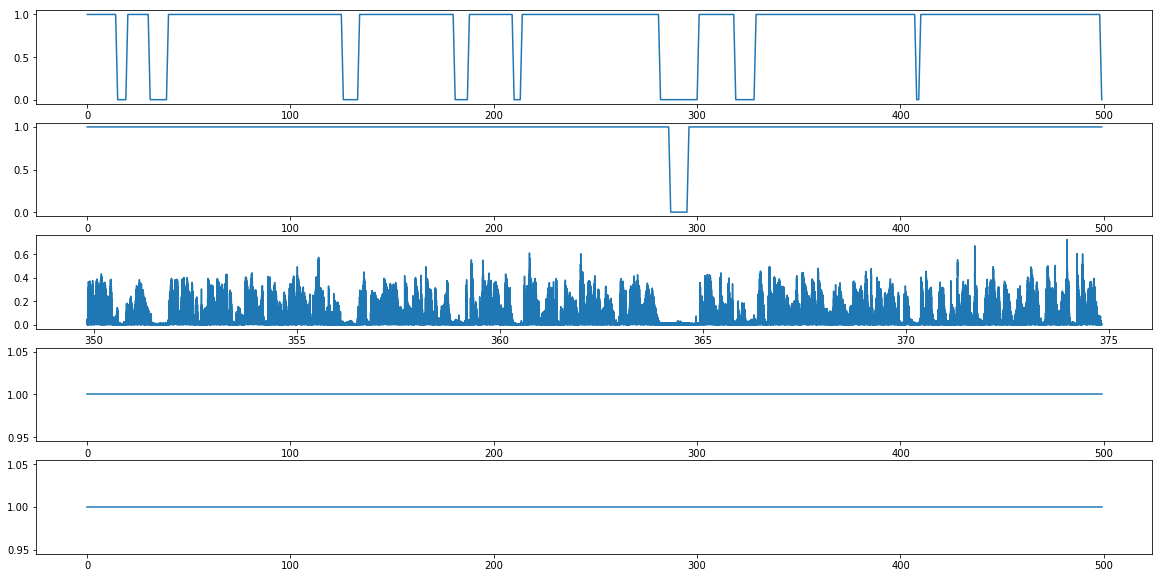

In [36]:
start = 7000
end = 7500
t = np.linspace(0, len(fe.wave)/fe.fs, num=len(fe.wave))
plt.figure(figsize=(20, 10))
plt.subplot(511)
plt.plot(fe.vad_value[start:end])
plt.subplot(512)
plt.plot(daf[start:end])
plt.subplot(513)
plt.plot(t[start*fe.frame_shift:end*fe.frame_shift], np.abs(wave)[start*fe.frame_shift:end*fe.frame_shift])
plt.subplot(514)
plt.plot(bdhv[start:end])
plt.subplot(515)
plt.plot(hangover2[start:end])
play((fe.wave)[start*fe.frame_shift:end*fe.frame_shift], fe.fs)

In [10]:
print("wave_sample_length:  ",fe.wave.shape)
print("fs", fe.fs)
print(fe.frame_len)
print(fe.frame_shift)
print(fe.stft.shape)
t.shape[0] == wave.shape[0]

wave_sample_length:   (19076608,)
fs 22050
2205
1102
(1103, 17311)


True

In [69]:
len(fe.wave)/fe.fs

865.1522902494331

FFT 정리

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [18]:
Fs = 2000 #sampling frequency, 초당 몇 번 sampling하는지
T = 1/Fs # sample interval time, sampling당 몇 초인지
te = 0.5 # End of time
t = np.arange(0, te, T) # 총 시간, time vector

noise = np.random.normal(0, 0.05, len(t))
x = 0.6*np.cos(2*np.pi*60*t+np.pi/2) + np.cos(2*np.pi*120*t) 
y = x + noise

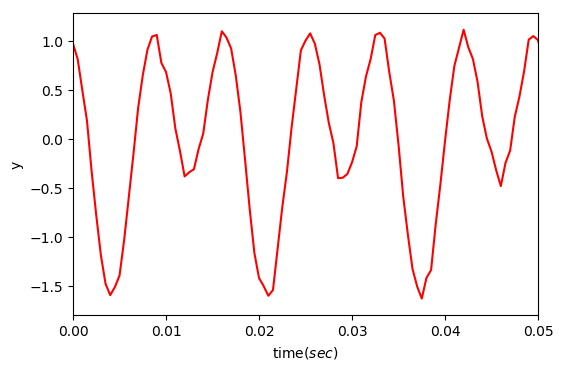

In [21]:
plt.figure(num=1, dpi=100, facecolor='white')
plt.plot(t, y, 'r')
plt.xlim(0, 0.05)
plt.xlabel('time($sec$)')
plt.ylabel('y')
plt.show()

In [30]:
n = len(y) # Length of signal
NFFT = n # fft할 개수
k = np.arange(NFFT)
f0 = k*Fs/NFFT
f0 = f0[range(math.trunc(NFFT/2))]
Y = np.fft.fft(y)/NFFT
amplitude_Hz = 2*abs(Y)
phase_ang = np.angle(Y)*180/np.pi

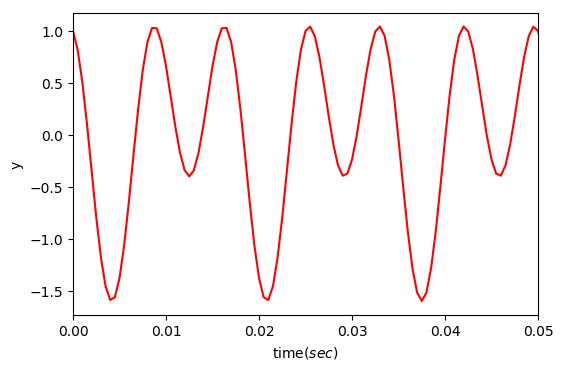

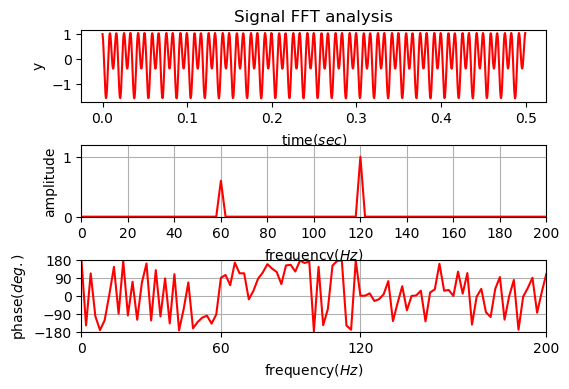

In [31]:
# FFT  그래프 그리기 1

import matplotlib.pyplot as plt
import numpy as np
import math

#St=0.0005

#Fs = 1/St                    # Sampling frequency
Fs = 2000                    # Sampling frequency
T = 1/Fs                     # Sample interval time
te= 0.5                     # End of time
t = np.arange(0, te, T)   # Time vector

# Sum of a 50 Hz sinusoid and a 120 Hz sinusoid
noise = np.random.normal(0,0.05,len(t))
x = 0.6*np.cos(2*np.pi*60*t+np.pi/2) + np.cos(2*np.pi*120*t)
y = x # + noise     # Sinusoids plus noise

# if energy was collapsed by forced code like belows...
#BB=range(math.trunc(len(t)/2), len(t))
#y[BB]=0

plt.figure(num=1,dpi=100,facecolor='white')
plt.plot(t,y,'r')
plt.xlim( 0, 0.05)
plt.xlabel('time($sec$)')
plt.ylabel('y')

# Calculate FFT ....................
n=len(y)        # Length of signal
NFFT=n      # ?? NFFT=2^nextpow2(length(y))  ??
k=np.arange(NFFT)
f0=k*Fs/NFFT    # double sides frequency range
f0=f0[range(math.trunc(NFFT/2))]        # single sied frequency range

Y=np.fft.fft(y)/NFFT        # fft computing and normaliation
Y=Y[range(math.trunc(NFFT/2))]          # single sied frequency range
amplitude_Hz = 2*abs(Y)
phase_ang = np.angle(Y)*180/np.pi

# figure 1 ..................................
plt.figure(num=2,dpi=100,facecolor='white')
plt.subplots_adjust(hspace = 0.6, wspace = 0.3)
plt.subplot(3,1,1)

plt.plot(t,y,'r')
plt.title('Signal FFT analysis')
plt.xlabel('time($sec$)')
plt.ylabel('y')
#plt.xlim( 0, 0.1)

# Amplitude ....
#plt.figure(num=2,dpi=100,facecolor='white')
plt.subplot(3,1,2)

# Plot single-sided amplitude spectrum.

plt.plot(f0,amplitude_Hz,'r')   #  2* ???
plt.xticks(np.arange(0,500,20))
plt.xlim( 0, 200)
plt.ylim( 0, 1.2)
#plt.title('Single-Sided Amplitude Spectrum of y(t)')
plt.xlabel('frequency($Hz$)')
plt.ylabel('amplitude')
plt.grid()

# Phase ....
#plt.figure(num=2,dpi=100,facecolor='white')
plt.subplot(3,1,3)
plt.plot(f0,phase_ang,'r')   #  2* ???
plt.xlim( 0, 200)
plt.ylim( -180, 180)
#plt.title('Single-Sided Phase Spectrum of y(t)')
plt.xlabel('frequency($Hz$)')
plt.ylabel('phase($deg.$)')
plt.xticks([0, 60, 120, 200])
plt.yticks([-180, -90, 0, 90, 180])
plt.grid()

plt.savefig("./test_figure2.png",dpi=300)
plt.show()

In [69]:
wave_t = wave[:100000]

frame_len = int(25 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
frames = librosa.util.frame(wave_t, frame_length=frame_len, hop_length=frame_shift)

pitches, magnitudes = librosa.core.piptrack(wave_t, sr=fs, hop_length=frame_shift, threshold=0.75)

In [104]:
frames.shape

551 *453

249603

In [82]:
t = np.asarray(wave_t)
t = np.arange(100000)

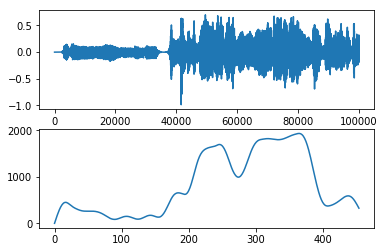

In [94]:
pitch_track = extract_max(pitches, pitches.shape)
pitch_smoothtrack = smooth(pitch_track, window_len=50)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, wave_t)
plt.subplot(2, 1, 2)
plt.plot(pitch_smoothtrack)
plt.show()